In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.utils import draw_bounding_boxes

In [2]:
SEED = 265
torch.manual_seed(SEED)
torch.set_default_dtype(torch.double)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

## 2 Object Localization
#### First we load and inspect the localization_*** datasets

In [3]:
train_data = torch.load('data/localization_train.pt')
val_data = torch.load('data/localization_val.pt')
test_data = torch.load('data/localization_test.pt')

In [4]:
print(f'Train data size: {len(train_data)}')
print(f'Val data size: {len(val_data)}')
print(f'Test data size: {len(test_data)}')

Train data size: 59400
Val data size: 6600
Test data size: 11000


In [5]:
first_img, first_label = train_data[0]

print(f'Shape of first image: {first_img.shape}')
print(f'Type of first image: {type(first_img)}')

print(f'\nShape of first label: {first_label.shape}')
print(f'Type of first label: {type(first_label)})')
first_label

Shape of first image: torch.Size([1, 48, 60])
Type of first image: <class 'torch.Tensor'>

Shape of first label: torch.Size([6])
Type of first label: <class 'torch.Tensor'>)


tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000], dtype=torch.float32)

In [6]:
def count_instances(data, data_name=None) -> None:
    """Counts the number of instances of each class in a dataset"""
    counter = Counter([int(label[-1]) for _, label in data])
    sorted_counter = dict(sorted(counter.items()))
    if data_name is not None:
        print(f'Class distribution in {data_name}')
    for key, value in sorted_counter.items():
        print(f'{key}: {value}')

count_instances(train_data, 'Training Data')
count_instances(val_data, 'Validation Data')
count_instances(test_data, 'Test Data')

Class distribution in Training Data
0: 5345
1: 11475
2: 5365
3: 5522
4: 5243
5: 4889
6: 5310
7: 5644
8: 5249
9: 5358
Class distribution in Validation Data
0: 578
1: 1267
2: 593
3: 609
4: 599
5: 532
6: 608
7: 621
8: 602
9: 591
Class distribution in Test Data
0: 980
1: 2135
2: 1032
3: 1010
4: 982
5: 892
6: 958
7: 1028
8: 974
9: 1009


In [20]:
train_data[0][0].shape
#høyde bredde

torch.Size([1, 48, 60])

#### Plotting one image from each class

tensor([13, 30, 18, 24], dtype=torch.uint8)


IndexError: too many indices for tensor of dimension 1

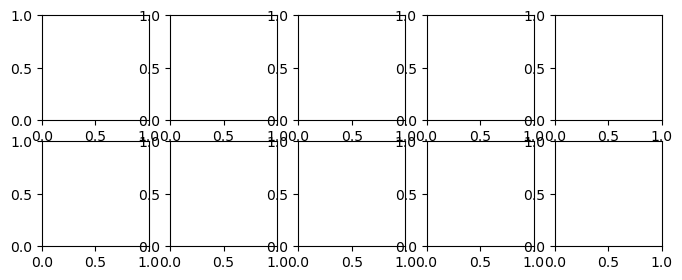

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,3))

for i, ax in enumerate(axes.flat): 
    img, bbox_normalized = next((img, label[1:5]) for img, label in train_data if int(label[-1]) == i)
    img_height, img_width = train_data[0][0].shape[-2], train_data[0][0].shape[-1]
    bbox = bbox_normalized.clone()
    bbox[0] *= img_width # xmin
    bbox[1] *= img_height # ymin
    bbox[2] *= img_width  # xmax
    bbox[3] *= img_height  # ymax
    bbox = bbox.type(torch.uint8)
    print(bbox)
    img_with_bbox = draw_bounding_boxes(img.type(torch.uint8), bbox)
    img_with_bbox  = img_with_bbox.numpy().transpose((1, 2, 0))
    #img = img.numpy().transpose((1, 2, 0))
    ax.imshow(img_with_bbox, cmap='gray')
    ax.set_title(i)
    ax.axis('off')

In [ ]:
def plot_class(data:torch.tensor, class_label:int, start_idx:int=0) -> None:
    """Plots a subplot with 10 images from a given class, starting at a chosen index
    Parameters:
    data: torch.tensor
        Data containing images and labels
    class_label: int
        The class to plot images from
    start_idx: int
        The index of the first image to be plotted. If start_idx=n, the subplot will contain 
        the n'th to the n+10'th image from the class
    Returns:
    None"""
    class_images = [img for img, label in data if int(label[-1]) == class_label]
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,3))

    for i, ax in enumerate(axes.flat):
        idx = start_idx + i
        img = class_images[idx]
        img = img.numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img, cmap='gray')
        plt.suptitle(f'CLASS {class_label} - Image {start_idx} to {idx}')
        ax.axis('off')

    plt.show()

plot_class(train_data, 3, 10)

#### Defining a normalizer and a preprocessor

In [ ]:
imgs = torch.stack([img for img, _ in train_data])

# Define normalizer
normalizer_pipe = transforms.Normalize(
    imgs.mean(dim=(0, 2, 3)), 
    imgs.std(dim=(0, 2, 3))
    )

# Definer preprocessor including the normalizer
preprocessor = transforms.Compose([
            transforms.ToTensor(),
            normalizer_pipe
        ])

In [ ]:
train_data = torch.load('data/localization_train.pt')
val_data = torch.load('data/localization_val.pt')
test_data = torch.load('data/localization_test.pt')